<a href="https://colab.research.google.com/github/pankajagrawal925/movie-review-sentiment-analysis_BiLSTM/blob/master/sentiment_analysis_movie_review_using_BiLSTM_Attention_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:

import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec
from gensim.models import KeyedVectors
import string
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import WordNetLemmatizer, PorterStemmer
ps = PorterStemmer()
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from sklearn import svm
import itertools
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
#import cufflinks as cf
#cf.go_offline()
#cf.set_config_file(offline=False, world_readable=True)
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import tqdm
import contractions
from bs4 import BeautifulSoup
import unicodedata
import gensim
#from tensorflow import keras
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.layers import Flatten
#from tensorflow.keras.layers import Conv1D
#from tensorflow.keras.layers import MaxPooling1D
#from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
!pip install cufflinks --upgrade

Requirement already up-to-date: cufflinks in /usr/local/lib/python3.6/dist-packages (0.16)


In [0]:
from google.colab import files
uploaded = files.upload()


Saving train.tsv to train (1).tsv


In [0]:
!pip install textsearch

In [0]:
import io
df = pd.read_csv(io.BytesIO(uploaded['train.tsv']),sep='\t')

In [0]:
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [0]:
df.isnull().sum()

NameError: ignored

In [0]:
df.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [0]:
df.Sentiment.value_counts().sort_values(ascending=False).iplot(kind='bar',yTitle='Number of reviews')

In [0]:
#text Pre-Processing
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: a modified initial string
    """
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub(' ',text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text
df['Phrase'] = df['Phrase'].apply(clean_text)
df['Phrase'] = df['Phrase'].str.replace('\d+','')

In [0]:
#some more text-PreProcessing
def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

Phrase_reviews = df['Phrase'].values
norm_phrases = pre_process_corpus(Phrase_reviews)

100%|██████████| 156060/156060 [00:20<00:00, 7598.83it/s]


In [0]:
df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,series escapades demonstrating adage good goos...,1
1,2,1,series escapades demonstrating adage good goose,2
2,3,1,series,2
3,4,1,,2
4,5,1,series,2


In [0]:
!!pip install contractions --upgrade

['Requirement already up-to-date: contractions in /usr/local/lib/python3.6/dist-packages (0.0.21)']

In [0]:
df.isnull().sum()

PhraseId      0
SentenceId    0
Phrase        0
Sentiment     0
dtype: int64

In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [0]:
#To prepare text data for our deep learning model, we transform each review into a sequence. Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

#To perform this transformation, keras provides the Tokenizer
t = Tokenizer(oov_token = '<UNK>')
#Fit on data
t.fit_on_texts(norm_phrases)
t.word_index['<PAD>'] = 0

In [0]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('harmlessly', 14999), ('<PAD>', 0), 1)

In [0]:
sequences = t.texts_to_sequences(norm_phrases)

In [0]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Document size={}".format(t.document_count))

Vocabulary size=15000
Document size=156060


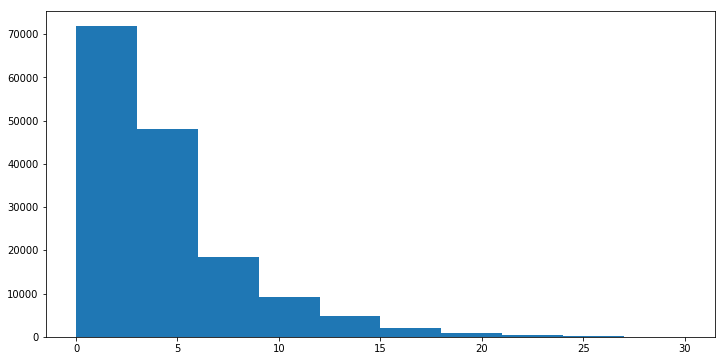

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

sequences_lens = [len(s) for s in sequences]

fig,ax = plt.subplots(1, figsize=(12, 6))
h1 = ax.hist(sequences_lens)


In [0]:
#Sequence Normalization
#Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length. For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

MAX_SEQUENCE_LENGTH = 1000

X = sequence.pad_sequences(sequences,maxlen = MAX_SEQUENCE_LENGTH)
y = to_categorical(df.Sentiment)
VOCAB_SIZE = len(t.word_index)
X.shape,y.shape

((156060, 1000), (156060, 5))

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape, y_train.shape

((124848, 1000), (124848, 5))

In [0]:
X_test.shape,y_test.shape

((31212, 1000), (31212, 5))

In [0]:
from keras.engine.topology import Layer
from keras import backend as K
 

class AttentionLayer(Layer):
    
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        """
        
        self.supports_masking = True
        self.init = keras.initializers.get('glorot_uniform')

        self.W_regularizer = keras.regularizers.get(W_regularizer)
        self.b_regularizer = keras.regularizers.get(b_regularizer)

        self.W_constraint = keras.constraints.get(W_constraint)
        self.b_constraint = keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(AttentionLayer, self).__init__(**kwargs)
        

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
        

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    
    def call(self, x, mask=None):
        # TF backend doesn't support it
        # eij = K.dot(x, self.W) 
        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), 
                              K.reshape(self.W, (features_dim, 1))),
                        (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)
        weighted_input = x * a
        
        return K.sum(weighted_input, axis=1)

    
    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim
    
    
    def get_config(self):
        config = {'step_dim': self.step_dim}
        base_config = super(AttentionLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
# create the model
#import tensorflow as tf
import keras
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 256 # total LSTM units

# model = tf.keras.models.Sequential()
# model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# #model.add(tf.keras.layers.SpatialDropout1D(0.1))
# #model.add(tf.keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=False))
# x = keras.layers.Bidirectional(keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=True))(x)
# x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(5, activation="softmax"))


inp = keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,))
x = keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, trainable=True)(inp)
x = keras.layers.Bidirectional(keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=True))(x)
x = keras.layers.Bidirectional(keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=True))(x)
x = keras.layers.Bidirectional(keras.layers.CuDNNLSTM(LSTM_DIM, return_sequences=True))(x)
x = AttentionLayer(MAX_SEQUENCE_LENGTH)(x)
x = keras.layers.Dense(LSTM_DIM*2, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)
x = keras.layers.Dense(LSTM_DIM, activation='relu')(x)
x = keras.layers.Dropout(rate=0.2)(x)

outp = keras.layers.Dense(5, activation='softmax')(x)
# initialize the model
model = keras.models.Model(inputs=inp, outputs=outp)

model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 1000, 300)         4500000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 512)         1142784   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000, 512)         1576960   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1000, 512)         1576960   
_________________________________________________________________
attention_layer_2 (Attention (None, 512)               1512      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2626

In [0]:
# Fit the model
batch_size = 100
model.fit(X_train, y_train, epochs=2, batch_size=batch_size, 
          shuffle=True, validation_split=0.1, verbose=1)

Train on 112363 samples, validate on 12485 samples
Epoch 1/2
112363/112363 [==============================] - 3292s 29ms/step - loss: 1.1088 - acc: 0.5600 - val_loss: 0.9180 - val_acc: 0.6339
Epoch 2/2
112363/112363 [==============================] - 3288s 29ms/step - loss: 0.8500 - acc: 0.6578 - val_loss: 0.8638 - val_acc: 0.6448


In [0]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

31212/31212 [==============================] - 504s 16ms/step
Accuracy: 64.45%
